In [2]:

import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as smf
import linearmodels as lm

from linearmodels.panel import PooledOLS
from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects
from linearmodels.panel import compare
from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('display.max_columns', 500)


%matplotlib inline

In [3]:
df = pd.read_csv('D:/TNC-Demand-Model/Outputs/Chi_Estimation_File.csv')

In [4]:
for col in df.columns:
    print(col)

Unnamed: 0
YEAR
MONTH
ORIGIN
DESTINATION
Unnamed: 0_RAC_ORIGIN
Unnamed: 0_x
TOD
Pickup Census Tract
Dropoff Census Tract
DAY_PRIVATE
Trip Seconds_PRIVATE
Trip Miles_PRIVATE
Fare_PRIVATE
Tip_PRIVATE
Additional Charges_PRIVATE
Trip Total_PRIVATE
TRIPS_PRIVATE
Trips Pooled_PRIVATE
TRAVEL_TIME_MINUTES_PRIVATE
SPEED_PRIVATE
DAY_SHARED
Trip Seconds_SHARED
Trip Miles_SHARED
Fare_SHARED
Tip_SHARED
Additional Charges_SHARED
Trip Total_SHARED
TRIPS_SHARED
Trips Pooled_SHARED
TRAVEL_TIME_MINUTES_SHARED
SPEED_SHARED
Unnamed: 0_y
GEOID_PICKUP
GEOID_DROPOFF
DAY
Pickup Community Area
Dropoff Community Area
TRIPS_SHARED_UNSUPPRESSED
TRIPS_PRIVATE_UNSUPPRESSED
TRIPS_PRIVATE_SUPPRESSED
TRIPS_SHARED_SUPPRESSED
TRAVEL_TIME_MINUTES_UNSUPPRESSED
TRAVEL_TIME_MINUTES_SUPPRESSED
DISTANCE_UNSUPPRESSED
DISTANCE_SUPPRESSED
FARE_UNSUPPRESSED
FARE_SUPPRESSED
TIP_UNSUPPRESSED
TIP_SUPPRESSED
TAX_AND_SURGE_UNSUPPRESSED
TAX_AND_SURGE_SUPPRESSED
TOTAL_COST_UNSUPPRESSED
TOTAL_COST_SUPPRESSED
TRIPS_POOLED_UNSUPPRESSED
TRI

In [5]:
df = df.drop(['Unnamed: 0','Unnamed: 0_RAC_ORIGIN','Unnamed: 0_x','TOD','DAY_PRIVATE','DAY_SHARED','Unnamed: 0_y','DAY','Unnamed: 0_RAC_DESTINATION','Unnamed: 0_WAC_ORIGIN','Unnamed: 0_WAC_DESTINATION','Unnamed: 0.1'], axis = 1)

In [6]:
df['TOTAL_WORKERS_OD'] = df.TOTAL_WORKERS_ORIGIN + df.TOTAL_WORKERS_DESTINATION
df['TOTAL_JOBS_OD'] = df.TOTAL_JOBS_ORIGIN + df.TOTAL_JOBS_DESTINATION
df['HHLDS_MEAN_INCOME_OD'] = (df.HHLDS_MEAN_INCOME + df.HHLDS_MEAN_INCOME_DESTINATION)/2
df['AVG_VEH_PER_HHLD_OD'] = (df.AVG_VEH_PER_HHLD + df.AVG_VEH_PER_HHLD_DESTINATION)/2
df['HHLDS_0_VEH_OD'] = (df.HHLDS_0_VEH + df.HHLDS_0_VEH_DESTINATION)/2
df['MEDIAN_AGE_OD'] = (df.MEDIAN_AGE + df.MEDIAN_AGE_DESTINATION)/2
#df['TRIPS_SUPPRESSED'] = df['TRIPS_SUPPRESSED'].fillna(0)
#df['TRIPS_UNSUPPRESSED'] = df['TRIPS_UNSUPPRESSED'].fillna(0)
#df['TRIPS_ALL'] = df['TRIPS_ALL'].fillna(0)
df['TOTAL_POP_OD'] = df.TOTAL_POP + df.TOTAL_POP_DESTINATION
df['TOTAL_POP_AGE_85P_OD'] = df.AGE_85P + df.AGE_85P_DESTINATION
df['TOTAL_POP_25P_BACHELORS_HIGHER_OD'] = df.TOTAL_POP_25P_BACHELORS_HIGHER + df.TOTAL_POP_25P_BACHELORS_HIGHER_DESTINATION



In [7]:
#fill these nan with 0 because I need to rerun the ACS data scripts which will fix this issue
df['TOTAL_HHLDS_200KP'] = df['TOTAL_HHLDS_200KP'].fillna(0)
df['TOTAL_HHLDS_200KP_DESTINATION'] = df['TOTAL_HHLDS_200KP_DESTINATION'].fillna(0)
df['HHLDS_MEAN_INCOME_OD'] = df['HHLDS_MEAN_INCOME_OD'].fillna(0)

In [8]:
df['TOTAL_HHLDS_100K_PLUS'] = df['TOTAL_HHLDS_200KP']+df['TOTAL_HHLDS_100K_150K']+df['TOTAL_HHLDS_150K_200K']
df['TOTAL_HHLDS_100K_PLUS_DESTINATION'] = df['TOTAL_HHLDS_200KP_DESTINATION']+df['TOTAL_HHLDS_100K_150K_DESTINATION']+df['TOTAL_HHLDS_150K_200K_DESTINATION']

df['TOTAL_HHLDS_100K_PLUS_OD'] = df.TOTAL_HHLDS_100K_PLUS + df.TOTAL_HHLDS_100K_PLUS_DESTINATION
df['TOTAL_HHLDS_200KP_OD'] = df.TOTAL_HHLDS_200KP + df.TOTAL_HHLDS_200KP_DESTINATION

In [23]:
df['TRIPS_PRIVATE_LOG'] = np.log(1+df['TRIPS_PRIVATE'])
df['TRIPS_SHARED_LOG'] = np.log(df['TRIPS_SHARED']+1)

In [10]:
df['PRIVATE_TAX_LOG'] =np.log(1+df['PRIVATE_TAX'])
df['TOTAL_POP_OD_LOG'] =np.log(1+df['TOTAL_POP_OD'])
df['TOTAL_JOBS_OD_LOG'] =np.log(1+df['TOTAL_JOBS_OD'])
df['TOTAL_HHLDS_200KP_OD_LOG'] =np.log(1+df['TOTAL_HHLDS_200KP_OD'])
df['HHLDS_0_VEH_OD_LOG'] =np.log(1+df['HHLDS_0_VEH_OD'])
df['TRANSIT_TRAVEL_TIME_LOG'] =np.log(1+df['travel_time'])
df['SHARED_TAX_LOG'] =np.log(1+df['SHARED_TAX'])
df['HHLDS_MEAN_INCOME_OD_LOG'] =np.log(1+df['HHLDS_MEAN_INCOME_OD'])


In [11]:
df['ENTITY'] = df['ORIGIN'].astype(str) + '_' + df['DESTINATION'].astype(str)
df['TIME'] = df['YEAR'].astype(str) + '-' + df['MONTH'].astype(str)
df['TIME'] =  pd.to_datetime(df['TIME'])

In [12]:
df = df.set_index(['ENTITY', 'TIME'])

In [20]:
df['PRIVATE_MINUS_SHARED_TAX_DIFF_LOG'] = np.log(1+df['PRIVATE_TAX']-df['SHARED_TAX'])

In [24]:
#start with a basic log-transformed model... best linear model with dependent variable log transformed

mod = PanelOLS.from_formula("TRIPS_PRIVATE_LOG \
                       ~ TOTAL_POP_OD \
                       + TOTAL_JOBS_OD \
                       + PRIVATE_TAX_LOG \
                       + SHARED_TAX_LOG \
                       + TOTAL_HHLDS_200KP_OD \
                       + TOTAL_POP_AGE_85P_OD \
                       + TOTAL_POP_25P_BACHELORS_HIGHER_OD \
                       + HHLDS_0_VEH_OD \
                       + travel_time \
                       + EntityEffects ",
             data = df)

panel_ols_res = mod.fit()
print(panel_ols_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:      TRIPS_PRIVATE_LOG   R-squared:                        0.0063
Estimator:                   PanelOLS   R-squared (Between):              0.3443
No. Observations:             2472921   R-squared (Within):               0.0063
Date:                Fri, Jul 23 2021   R-squared (Overall):              0.3675
Time:                        16:52:11   Log-likelihood                 2.517e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1498.3
Entities:                      348082   P-value                           0.0000
Avg Obs:                       7.1044   Distribution:               F(9,2124830)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):             1498.3
                            

In [27]:
#tweak the tax variable

mod = PanelOLS.from_formula("TRIPS_PRIVATE_LOG \
                       ~ TOTAL_JOBS_OD \
                       + PRIVATE_MINUS_SHARED_TAX_DIFF_LOG \
                       + TOTAL_HHLDS_200KP_OD \
                       + TOTAL_POP_AGE_85P_OD \
                       + TOTAL_POP_25P_BACHELORS_HIGHER_OD \
                       + HHLDS_0_VEH_OD \
                       + travel_time \
                       + EntityEffects ",
             data = df)

panel_ols_res = mod.fit()
print(panel_ols_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:      TRIPS_PRIVATE_LOG   R-squared:                        0.0061
Estimator:                   PanelOLS   R-squared (Between):              0.3595
No. Observations:             2472921   R-squared (Within):               0.0061
Date:                Fri, Jul 23 2021   R-squared (Overall):              0.3764
Time:                        16:57:03   Log-likelihood                 2.516e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1876.6
Entities:                      348082   P-value                           0.0000
Avg Obs:                       7.1044   Distribution:               F(7,2124832)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):             1876.6
                            

In [26]:
#try shared trips as dep var

mod = PanelOLS.from_formula("TRIPS_SHARED_LOG \
                       ~ TOTAL_POP_OD \
                       + TOTAL_JOBS_OD \
                       + PRIVATE_MINUS_SHARED_TAX_DIFF_LOG \
                       + TOTAL_HHLDS_200KP_OD \
                       + TOTAL_POP_AGE_85P_OD \
                       + TOTAL_POP_25P_BACHELORS_HIGHER_OD \
                       + HHLDS_0_VEH_OD \
                       + travel_time \
                       + EntityEffects ",
             data = df)

panel_ols_res = mod.fit()
print(panel_ols_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:       TRIPS_SHARED_LOG   R-squared:                        0.0401
Estimator:                   PanelOLS   R-squared (Between):             -3.6348
No. Observations:             1891186   R-squared (Within):               0.0401
Date:                Fri, Jul 23 2021   R-squared (Overall):             -6.1919
Time:                        16:55:33   Log-likelihood                 2.194e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      8184.7
Entities:                      321835   P-value                           0.0000
Avg Obs:                       5.8763   Distribution:               F(8,1569343)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):             8184.7
                            

In [14]:
residuals = pd.DataFrame(panel_ols_res.resids)

residuals = residuals.unstack(level = -1)
residuals.head()

residual                                   \
TIME                        2018-11-01 2018-12-01 2019-01-01 2019-02-01   
ENTITY                                                                    
17031010100.0_17031010100.0  -0.077488   0.127585   0.162041   0.193986   
17031010100.0_17031010201.0  -0.110151   0.078153   0.088442   0.093539   
17031010100.0_17031010202.0  -0.135872  -0.061029   0.293520   0.069441   
17031010100.0_17031010300.0   0.036692  -0.098386   0.181027   0.207350   
17031010100.0_17031010400.0  -0.046371  -0.003616   0.120201   0.175207   

                                                                         \
TIME                        2019-03-01 2019-04-01 2019-05-01 2019-06-01   
ENTITY                                                                    
17031010100.0_17031010100.0   0.235972   0.072929   0.092787  -0.170062   
17031010100.0_17031010201.0   0.138218   0.055784  -0.039561  -0.072903   
17031010100.0_17031010202.0   0.107520  -0.000968  -0.016333  -0.090785   
17031010100.0_17031010300.0   0.128579  -0.086151  -0.083712  -0.061340   
17031010100.0_17031010400.0   0.171340   0.026861  -0.042216  -0.068883   

                                                                         \
TIME                        2019-07-01 2019-08-01 2019-09-01 2019-10-01   
ENTITY                                                                    
17031010100.0_17031010100.0  -0.147938  -0.167099  -0.055442  -0.185788   
17031010100.0_17031010201.0   0.023599  -0.157402  -0.148304  -0.001097   
17031010100.0_17031010202.0  -0.043618  -0.080330  -0.011926  -0.102122   
17031010100.0_17031010300.0  -0.004437  -0.106929  -0.123280        NaN   
17031010100.0_17031010400.0  -0.121162  -0.183173  -0.055378   0.014005   

                                                                         
TIME                        2019-11-01 2019-12-01 2020-01-01 2020-02-01  
ENTITY                                                                   
17031010100.0_17031010100.0  -0.063562  -0.127555  -0.059800   0.169435  
17031010100.0_17031010201.0  -0.010105   0.069165   0.000555  -0.007933  
17031010100.0_17031010202.0   0.086801   0.019600  -0.115540   0.081641  
17031010100.0_17031010300.0   0.098022  -0.102941   0.022373  -0.006866  
17031010100.0_17031010400.0  -0.046693   0.094057  -0.106172   0.071995

In [15]:
residuals.columns = residuals.columns.droplevel()
residuals.head()

TIME,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01
ENTITY,,,,,,,,,,,,,,,,
17031010100.0_17031010100.0,-0.077488,0.127585,0.162041,0.193986,0.235972,0.072929,0.092787,-0.170062,-0.147938,-0.167099,-0.055442,-0.185788,-0.063562,-0.127555,-0.059800,0.169435
17031010100.0_17031010201.0,-0.110151,0.078153,0.088442,0.093539,0.138218,0.055784,-0.039561,-0.072903,0.023599,-0.157402,-0.148304,-0.001097,-0.010105,0.069165,0.000555,-0.007933
17031010100.0_17031010202.0,-0.135872,-0.061029,0.293520,0.069441,0.107520,-0.000968,-0.016333,-0.090785,-0.043618,-0.080330,-0.011926,-0.102122,0.086801,0.019600,-0.115540,0.081641
17031010100.0_17031010300.0,0.036692,-0.098386,0.181027,0.207350,0.128579,-0.086151,-0.083712,-0.061340,-0.004437,-0.106929,-0.123280,NaN,0.098022,-0.102941,0.022373,-0.006866
17031010100.0_17031010400.0,-0.046371,-0.003616,0.120201,0.175207,0.171340,0.026861,-0.042216,-0.068883,-0.121162,-0.183173,-0.055378,0.014005,-0.046693,0.094057,-0.106172,0.071995


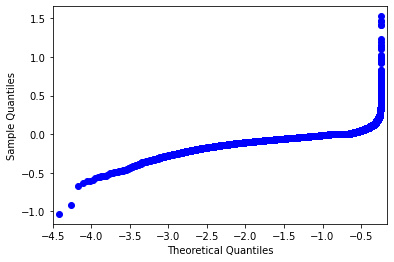

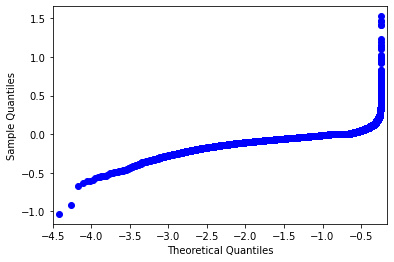

In [16]:
smf.graphics.qqplot(residuals['2020-02-01'],line = 'q')

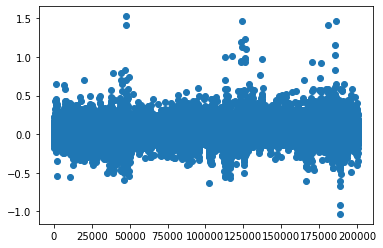

In [17]:

residual = pd.DataFrame()
residual['residual'] = residuals['2020-02-01']
residual.index = range(0,len(residual))
plt.scatter(residual.index,residual.residual)


C:\Users\transportlab\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='2020-02-01 00:00:00', ylabel='Density'>

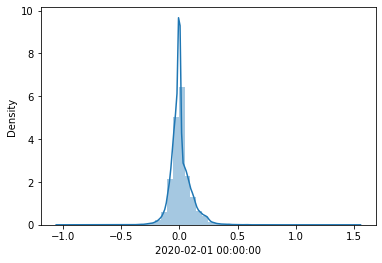

In [18]:
sns.distplot(residuals['2020-02-01'])

C:\Users\transportlab\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='2019-04-01 00:00:00', ylabel='Density'>

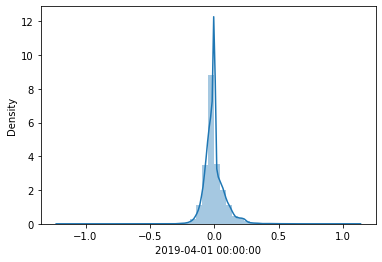

In [19]:
sns.distplot(residuals['2019-04-01'])